In [1]:
import os, sys
import pickle
import polars as pl

In [2]:
# Define el ID del experimento que quieres analizar
DATA_ID = 'dubai_houses' 

project_path = os.path.abspath(os.path.join(os.getcwd(), '..')) # Subir un nivel
results_dir = os.path.join(project_path, 'results', 'experiment_2', DATA_ID)
filename = f'results_exp_2_{DATA_ID}.pkl'
results_path = os.path.join(results_dir, filename)

sys.path.append(project_path)

from src.experiments_utils import plot_experiment_2_results
from config.config_experiment_2 import N_REALIZATIONS

In [3]:
# -------------------------------------------------------------------------
# CARGAR RESULTADOS
# -------------------------------------------------------------------------
if not os.path.exists(results_path):
    print("❌ Error: El archivo no existe. Revisa el DATA_ID o la ruta.")
else:
    with open(results_path, 'rb') as f:
        results = pickle.load(f)
    print(f"✅ Archivo cargado correctamente. Tipo de objeto: {type(results)}")
    print(f"📊 Número de realizaciones (seeds) capturadas: {len(results)}")

# -------------------------------------------------------------------------
# CONVERSIÓN A DATAFRAME  
# -------------------------------------------------------------------------
rows = []
for seed, metrics in results.items():   
    # Asumimos que todas las métricas tienen las mismas claves (frac_sample_sizes)
    frac_sample_sizes = metrics['ARI'].keys() 
    
    for frac in frac_sample_sizes:
        row = {
            'random_state': seed,
            'frac_sample_size': frac,
            'time': metrics['time'].get(frac),
            'adj_accuracy': metrics['adj_accuracy'].get(frac),
            'ARI': metrics['ARI'].get(frac)
        }
        rows.append(row)

df = pl.DataFrame(rows)

✅ Archivo cargado correctamente. Tipo de objeto: <class 'dict'>
📊 Número de realizaciones (seeds) capturadas: 100


In [4]:
df

random_state,frac_sample_size,time,adj_accuracy,ARI
i64,f64,f64,f64,f64
6863,0.05,0.639713,0.513819,-0.003575
6863,0.1,0.499909,0.826135,0.509823
6863,0.2,0.58402,0.824297,0.506473
6863,0.3,0.637621,0.825583,0.509644
6863,0.4,0.709719,0.822827,0.500522
…,…,…,…,…
30032,0.5,0.600472,0.824114,0.503672
30032,0.6,1.034418,0.822827,0.500522
30032,0.7,1.081895,0.822827,0.500522


In [5]:
df_avg = (
    df.group_by(['frac_sample_size'])
    .agg(pl.mean(['ARI', 'adj_accuracy', 'time']))
    .sort('frac_sample_size')
)

df_avg

frac_sample_size,ARI,adj_accuracy,time
f64,f64,f64,f64
0.05,0.467596,0.802566,0.72861
0.1,0.506913,0.825027,0.725183
0.2,0.505832,0.824578,0.706494
0.3,0.505375,0.824435,0.680417
0.4,0.504454,0.824137,0.682998
0.5,0.50347,0.823854,0.712496
0.6,0.50327,0.823744,0.742827
0.7,0.502821,0.823582,0.78246
0.8,0.501982,0.82332,0.86864


In [6]:
# VISUALIZATION PARAMETERS 

best_row = df_avg.sort("adj_accuracy", descending=True).row(0, named=True)

best_frac = best_row["frac_sample_size"]
best_acc = best_row["adj_accuracy"]
best_ari = best_row["ARI"]
best_time = best_row["time"]

# Preparamos los datos para ejes X (convertidos a porcentaje) e Y
x_data_pct = df_avg["frac_sample_size"] * 100
y_acc = df_avg["adj_accuracy"]
y_ari = df_avg["ARI"]
y_time = df_avg["time"]

plot_filename = f'plot_results_exp_2_{DATA_ID}.png'
save_path = os.path.join(results_dir, plot_filename)

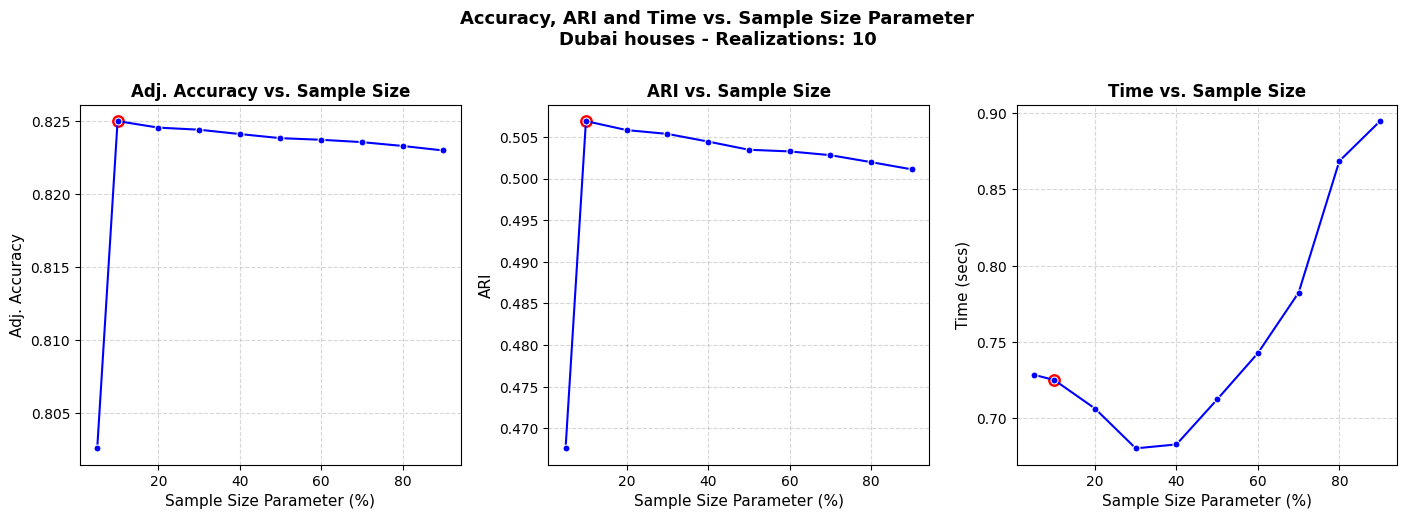

In [7]:
plot_experiment_2_results(
        best_frac, best_acc, best_ari, best_time, 
        x_data_pct, y_acc, y_ari, y_time,
        DATA_ID, N_REALIZATIONS, save_path
)